## NSL (0) vs VSSL (1)

### Import Libraries

In [1]:
from util_comp import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import time
import warnings

import xgboost


from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression

# Makes sure we see all columns
pd.set_option('display.max_columns', None)

# ignore warnings
warnings.filterwarnings('ignore')

### Load the data

In [2]:
df = pd.DataFrame(main(retained=True))
print(df.shape)
df.head()

Only retained columns are used
Shape of data: (44535, 72)
Elapsed time to compute age categorisation: 0 minutes and 0 seconds
Elapsed time to compute load column names: 0 minutes and 0 seconds
Elapsed time to compute clean data: 0 minutes and 0 seconds
Elapsed time to compute categorisation of outcome column: 0 minutes and 3 seconds
Elapsed time to compute change values in catagorical columns: 1 minutes and 9 seconds
Elapsed time to compute Full process: 1 minutes and 12 seconds
(37681, 67)


,Gender,Age,Work type,sector,size of business,No of 3 to 6 years old children,No of 7 to 12 years old children,No of 13 to 17 years old children,No of 18 years and over children,dependents,Full Time/Part Time,shift work with alternating hours,Place of work,standing or in an awkward posture,carry or move heavy loads,perform repetitive gestures,work on screen,cold/ hot env,work in noisy env,breathe toxic products or dust,handle toxic or dangerous products,risk of serious fall,machinery with exposure to injury,learn new things,work quickly or very intensely,long periods of concentration,physically tiring,mentally tiring,satisfaction with work,make decisions,difficulty managing priorities,recognized by my hierarchy,develop professional skills,good understanding where I work,well-suited workstation,seek to improve the way I work,well-being of its employees,Security is a priority,count on supervisor,recommend the company,decreased alertness,hurtful or aggressive remarks,insulted or attacked by the public or customers,clarity of your role in the company,access to professional training,tools or workstation,prospects for development,mastery of position,difficulty reconciling your work with your other personal commitments,transportation,personal concerns,can talk to loved ones,state of health in general,long-term illness,Disabilities,Headaches,"neck, shoulder, arm pain",back pain,"leg, foot, knee pain",other parts of the body pain,midday meal,drinks (At least once a week),smoker,"sleeping pills, anxiolytics or anti-depressants",Sleep disorders,lack of tone,outcome
0,A man,30 - 39,AM Technicians,Wholesale trade (all businesses in 206),250 - 999,1.0,2.0,0.0,0.0,No,Full time,No,In a shared office (3 to 5 people),Never,Never,Rarely,Most of the time,Most of the time,Never,No,No,No,No,Rather,Rather,Rather,Rather not,Rather,Rather,Rather,Rather not,Rather,Rather,Rather,Rather,Rather,Rather,Rather,Rather,NaN,Sometimes,Never,Never,NaN,NaN,NaN,NaN,NaN,"Yes, rather",Less than 1 hour per day,Rather not,NaN,Good,No,No,Never,Never,Never,Often,Never,When returning home,Alcoholic beverages,Yes,Never,sometimes,sometimes,SSL
1,A man,18 - 30,Frames,Wholesale trade (all businesses in 206),50 - 249,0.0,0.0,0.0,0.0,No,Full time,No,In a shared office (3 to 5 people),Rarely,Never,Rarely,Most of the time,Never,Most of the time,No,No,No,Yes,Rather,Rather,Rather,Rather not,Completely,Rather,Rather,Rather not,Rather,Rather not,Completely,Rather,Rather,Completely,Completely,Rather,NaN,Sometimes,Never,Very Often,NaN,NaN,NaN,NaN,NaN,"No, rather not",Less than 1 hour per day,Not at all,NaN,Good,No,No,Sometimes,Sometimes,Sometimes,Permanently,Permanently,By bringing your meal from home,Alcoholic beverages,No,Never,Never,Never,VSSL
2,A woman,45 - 49,Employees,Wholesale trade (all businesses in 206),0 - 10,0.0,0.0,1.0,1.0,No,Full time,No,At home teleworking,Rarely,Rarely,Rarely,Never,Never,Never,No,No,No,No,Completely,Rather not,Rather,Rather not,Rather not,Rather,Completely,Rather not,Rather not,Rather,Completely,Rather,Completely,Rather,Completely,Rather not,NaN,Sometimes,Never,Never,NaN,NaN,NaN,NaN,NaN,No not at all,Less than 1 hour per day,Not at all,NaN,Good,Yes,No,Sometimes,Sometimes,Sometimes,Never,Sometimes,When returning home,NaN,No,Never,often,sometimes,LSL
3,A man,30 - 39,Frames,Wholesale trade (all businesses in 206),50 - 249,0.0,0.0,0.0,0.0,No,Full time,No,In a shared office (3 to 5 people),NaN,Most of the time,Most of the time,Most of the time,Rarely,Rarely,No,No,No,No,Rather not,Completely,Completely,Rather,Completely,Rather,Completely,Not at all,Not at all,Rather,Rather,Rather,Rather,Not at all,Rather,Not at all,NaN,Very Often,Very Often,Very Often,NaN,NaN,NaN,NaN,NaN,"Yes, rather",Between 1 hour and 2 hours per day,Rather not,NaN,Good,Yes,No,Often,Often,Often,Often,Often,While eating a sandwich,NaN,No,Never,sometimes,often,NoSL
4,A man,56 - 70,Workers,Industry,Oct-49,0.0,0.0,0.0,0.0,No,Full time,Yes,"In a workshop, a technical room",Most of the time,Most

In [3]:
df["outcome"].value_counts()

NoSL    24060
LSL      5662
VSSL     4698
SSL      3261
Name: outcome, dtype: int64

In [4]:
from pandas.api.types import CategoricalDtype
cat_dtype = CategoricalDtype(
    categories=["NoSL", "VSSL", "SSL", "LSL"], ordered=True)

for cols in df.columns:
    if cols not in not_cat:
        if cols == "outcome":
            df[cols] = df[cols].astype(cat_dtype)
        df[cols] = df[cols].astype("category").cat.codes

In [5]:
df["outcome"].value_counts()

0    24060
3     5662
1     4698
2     3261
Name: outcome, dtype: int64

#### split data to train and test sets

In [6]:
data = df

# Split the data for training and evaluation
# X: features with the outcome column removed, where outcome is 0 or 1
# y: outcome column

# get the rows withs outcome 0 or 1
X = data[(data['outcome'] == 0) | (data['outcome'] == 1)].drop('outcome', axis=1, inplace=False)
X.columns = [str(i) for i in X.columns]
y = data[(data['outcome'] == 0) | (data['outcome'] == 1)]['outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


#### Train the Random Forest model

In [7]:
# Fit RF (blackbox) model
t1 = time.time()
sl = RandomForestClassifier(class_weight='balanced_subsample', n_estimators=100, random_state=0)
sl.fit(X_train, y_train)
t2 = time.time()
print(time_e(t1, t2, "fitting RF model"))

Elapsed time to compute fitting RF model: 0 minutes and 2 seconds


In [8]:
y_pred = sl.predict(X_test)
y_pred_proba = sl.predict_proba(X_test)

In [9]:
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy of test: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy of train: {accuracy_score(y_train, sl.predict(X_train))}")

# ROAUC

print(f"ROAUC: {roc_auc_score(y_test, y_pred_proba[:,1])}")
print(f"Confusin matrix: \n{confusion_matrix(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

F1 Score: 0.47138837975491366
Accuracy of test: 0.8379694019471489
Accuracy of train: 1.0
ROAUC: 0.6887963210617672
Confusin matrix: 
[[4805    2]
 [ 930   15]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      4807
           1       0.88      0.02      0.03       945

    accuracy                           0.84      5752
   macro avg       0.86      0.51      0.47      5752
weighted avg       0.85      0.84      0.77      5752



## Explanantion using SHAP

In [10]:
explainer = shap.TreeExplainer(sl)

# Calculate shapley values for test data
start_index = 0
end_index = 10

# time to run 10 samples
s_time = time.time()
shap_values = explainer.shap_values(X_test[start_index:end_index]) # 0 - 9
e_time = time.time()
time_e(s_time, e_time, f"Shapley values for test data[{start_index}:{end_index}]")
X_test[start_index:end_index]

,Gender,Age,Work type,sector,size of business,No of 3 to 6 years old children,No of 7 to 12 years old children,No of 13 to 17 years old children,No of 18 years and over children,dependents,Full Time/Part Time,shift work with alternating hours,Place of work,standing or in an awkward posture,carry or move heavy loads,perform repetitive gestures,work on screen,cold/ hot env,work in noisy env,breathe toxic products or dust,handle toxic or dangerous products,risk of serious fall,machinery with exposure to injury,learn new things,work quickly or very intensely,long periods of concentration,physically tiring,mentally tiring,satisfaction with work,make decisions,difficulty managing priorities,recognized by my hierarchy,develop professional skills,good understanding where I work,well-suited workstation,seek to improve the way I work,well-being of its employees,Security is a priority,count on supervisor,recommend the company,decreased alertness,hurtful or aggressive remarks,insulted or attacked by the public or customers,clarity of your role in the company,access to professional training,tools or workstation,prospects for development,mastery of position,difficulty reconciling your work with your other personal commitments,transportation,personal concerns,can talk to loved ones,state of health in general,long-term illness,Disabilities,Headaches,"neck, shoulder, arm pain",back pain,"leg, foot, knee pain",other parts of the body pain,midday meal,drinks (At least once a week),smoker,"sleeping pills, anxiolytics or anti-depressants",Sleep disorders,lack of tone
23218,1,1,3,6,1,1.0,0.0,1.0,0.0,0,0,1,7,2,1,0,0,3,2,1,0,0,0,2,2,2,3,2,2,2,1,2,2,3,2,3,2,2,0,2,2,2,2,0,0,0,0,0,1,2,1,0,2,0,0,3,3,3,3,0,0,0,1,2,0,3
34972,0,2,3,0,1,1.0,1.0,0.0,0.0,2,0,0,9,0,2,2,1,0,0,1,0,0,0,2,2,2,0,2,2,2,3,2,2,2,2,2,2,0,0,2,0,0,0,0,0,0,0,0,1,2,3,3,2,0,0,3,0,1,3,3,0,1,1,2,1,3
11207,0,1,0,6,0,0.0,0.0,0.0,0.0,0,0,0,3,1,1,1,0,1,2,0,0,0,0,2,0,0,1,0,3,2,3,2,2,2,2,0,2,2,2,3,2,0,0,1,1,0,1,1,3,1,2,0,0,0,0,1,1,1,1,3,0,1,1,2,1,1
14277,0,4,3,2,1,0.0,0.0,0.0,0.0,0,0,0,3,2,3,1,2,2,2,0,0,0,0,0,2,0,1,0,2,0,2,2,0,0,2,0,2,2,2,2,2,2,1,0,0,0,0,0,3,0,3,0,2,0,0,3,3,3,3,3,1,1,0,2,3,3
35125,0,2,2,3,1,0.0,2.0,2.0,0.0,0,0,0,7,1,1,1,0,1,1,0,0,0,0,3,2,2,1,2,2,0,3,2,2,2,2,2,2,0,2,2,2,0,0,0,0,0,1,0,1,0,2,2,4,0,0,0,0,3,0,0,1,0,0,2,0,3
27895,0,0,3,3,1,0.0,0.0,0.0,0.0,0,0,1,6,3,0,3,2,2,2,1,1,0,0,0,2,0,3,2,0,0,2,3,0,2,2,2,0,2,2,2,2,1,1,0,0,0,1,1,3,0,2,0,2,0,1,0,3,1,3,3,4,0,0,3,3,1
29801,1,3,0,2,2,0.0,0.0,0.0,0.0,0,0,0,3,0,2,3,2,3,1,0,0,0,0,0,0,2,0,0,2,-1,3,2,2,0,2,2,2,2,2,2,2,0,2,0,0,1,1,0,0,2,1,0,2,0,0,3,3,1,3,3,3,0,0,2,3,3
16423,1,1,2,6,1,1.0,0.0,0.0,0.0,0,0,0,6,0,0,2,2,3,0,1,1,0,0,3,2,0,2,0,2,0,3,3,3,3,2,2,3,3,1,1,2,2,1,0,1,0,1,0,1,2,2,3,0,0,0,1,1,1,3,3,0,1,0,2,3,1
8510,0,0,0,6,2,1.0,0.0,0.0,0.0,2,0,1,8,2,2,2,0,3,0,1,0,0,1,0,0,0,2,2,2,2,3,3,2,2,2,0,3,1,2,-1,2,2,0,1,1,1,1,-1,3,0,3,0,2,0,0,1,1,1,3,0,4,0,1,2,3,0
8356,0,0,2,6,2,0.0,0.0,0.0,0.0,0,0,0,8,1,1,3,0,2,2,0,0,0,0,2,0,0,3,3,2,2,1,2,2,0,2,2,3,2,2,-1,2,2,2,0,1,0,1,-1,3,2,3,3,2,0,0,1,0,1,3,0,2,0,0,2,3,3


In [11]:
y_test[start_index:end_index]

23218    0
34972    0
11207    1
14277    0
35125    0
27895    0
29801    0
16423    1
8510     1
8356     1
Name: outcome, dtype: int8

### SHAP Values

In [12]:
print(shap_values[0].shape)
shap_values

(66, 2)


array([[[ 0.00373401, -0.00373401],
        [-0.01967264,  0.01967264],
        [ 0.01583675, -0.01583675],
        ...,
        [ 0.00514489, -0.00514489],
        [ 0.0174294 , -0.0174294 ],
        [-0.0074232 ,  0.0074232 ]],

       [[ 0.0031239 , -0.0031239 ],
        [ 0.01794593, -0.01794593],
        [ 0.00914681, -0.00914681],
        ...,
        [ 0.00305599, -0.00305599],
        [ 0.00417699, -0.00417699],
        [-0.00046381,  0.00046381]],

       [[ 0.01094542, -0.01094542],
        [-0.03521318,  0.03521318],
        [ 0.01626494, -0.01626494],
        ...,
        [ 0.00243121, -0.00243121],
        [ 0.0097774 , -0.0097774 ],
        [-0.00696601,  0.00696601]],

       ...,

       [[ 0.00112284, -0.00112284],
        [-0.02119928,  0.02119928],
        [ 0.0055095 , -0.0055095 ],
        ...,
        [ 0.00383376, -0.00383376],
        [-0.00024044,  0.00024044],
        [-0.00407859,  0.00407859]],

       [[ 0.00693585, -0.00693585],
        [-0.02168426,  0.02

In [13]:
shap.initjs()
# Force plot
prediction = sl.predict(X_test[start_index:end_index])[0]
print(f"The sl predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                shap_values[...,1],
                X_test[start_index:end_index])  # for values

The sl predicted: 0


### Summary of Variables that affected the prediction using SHAP

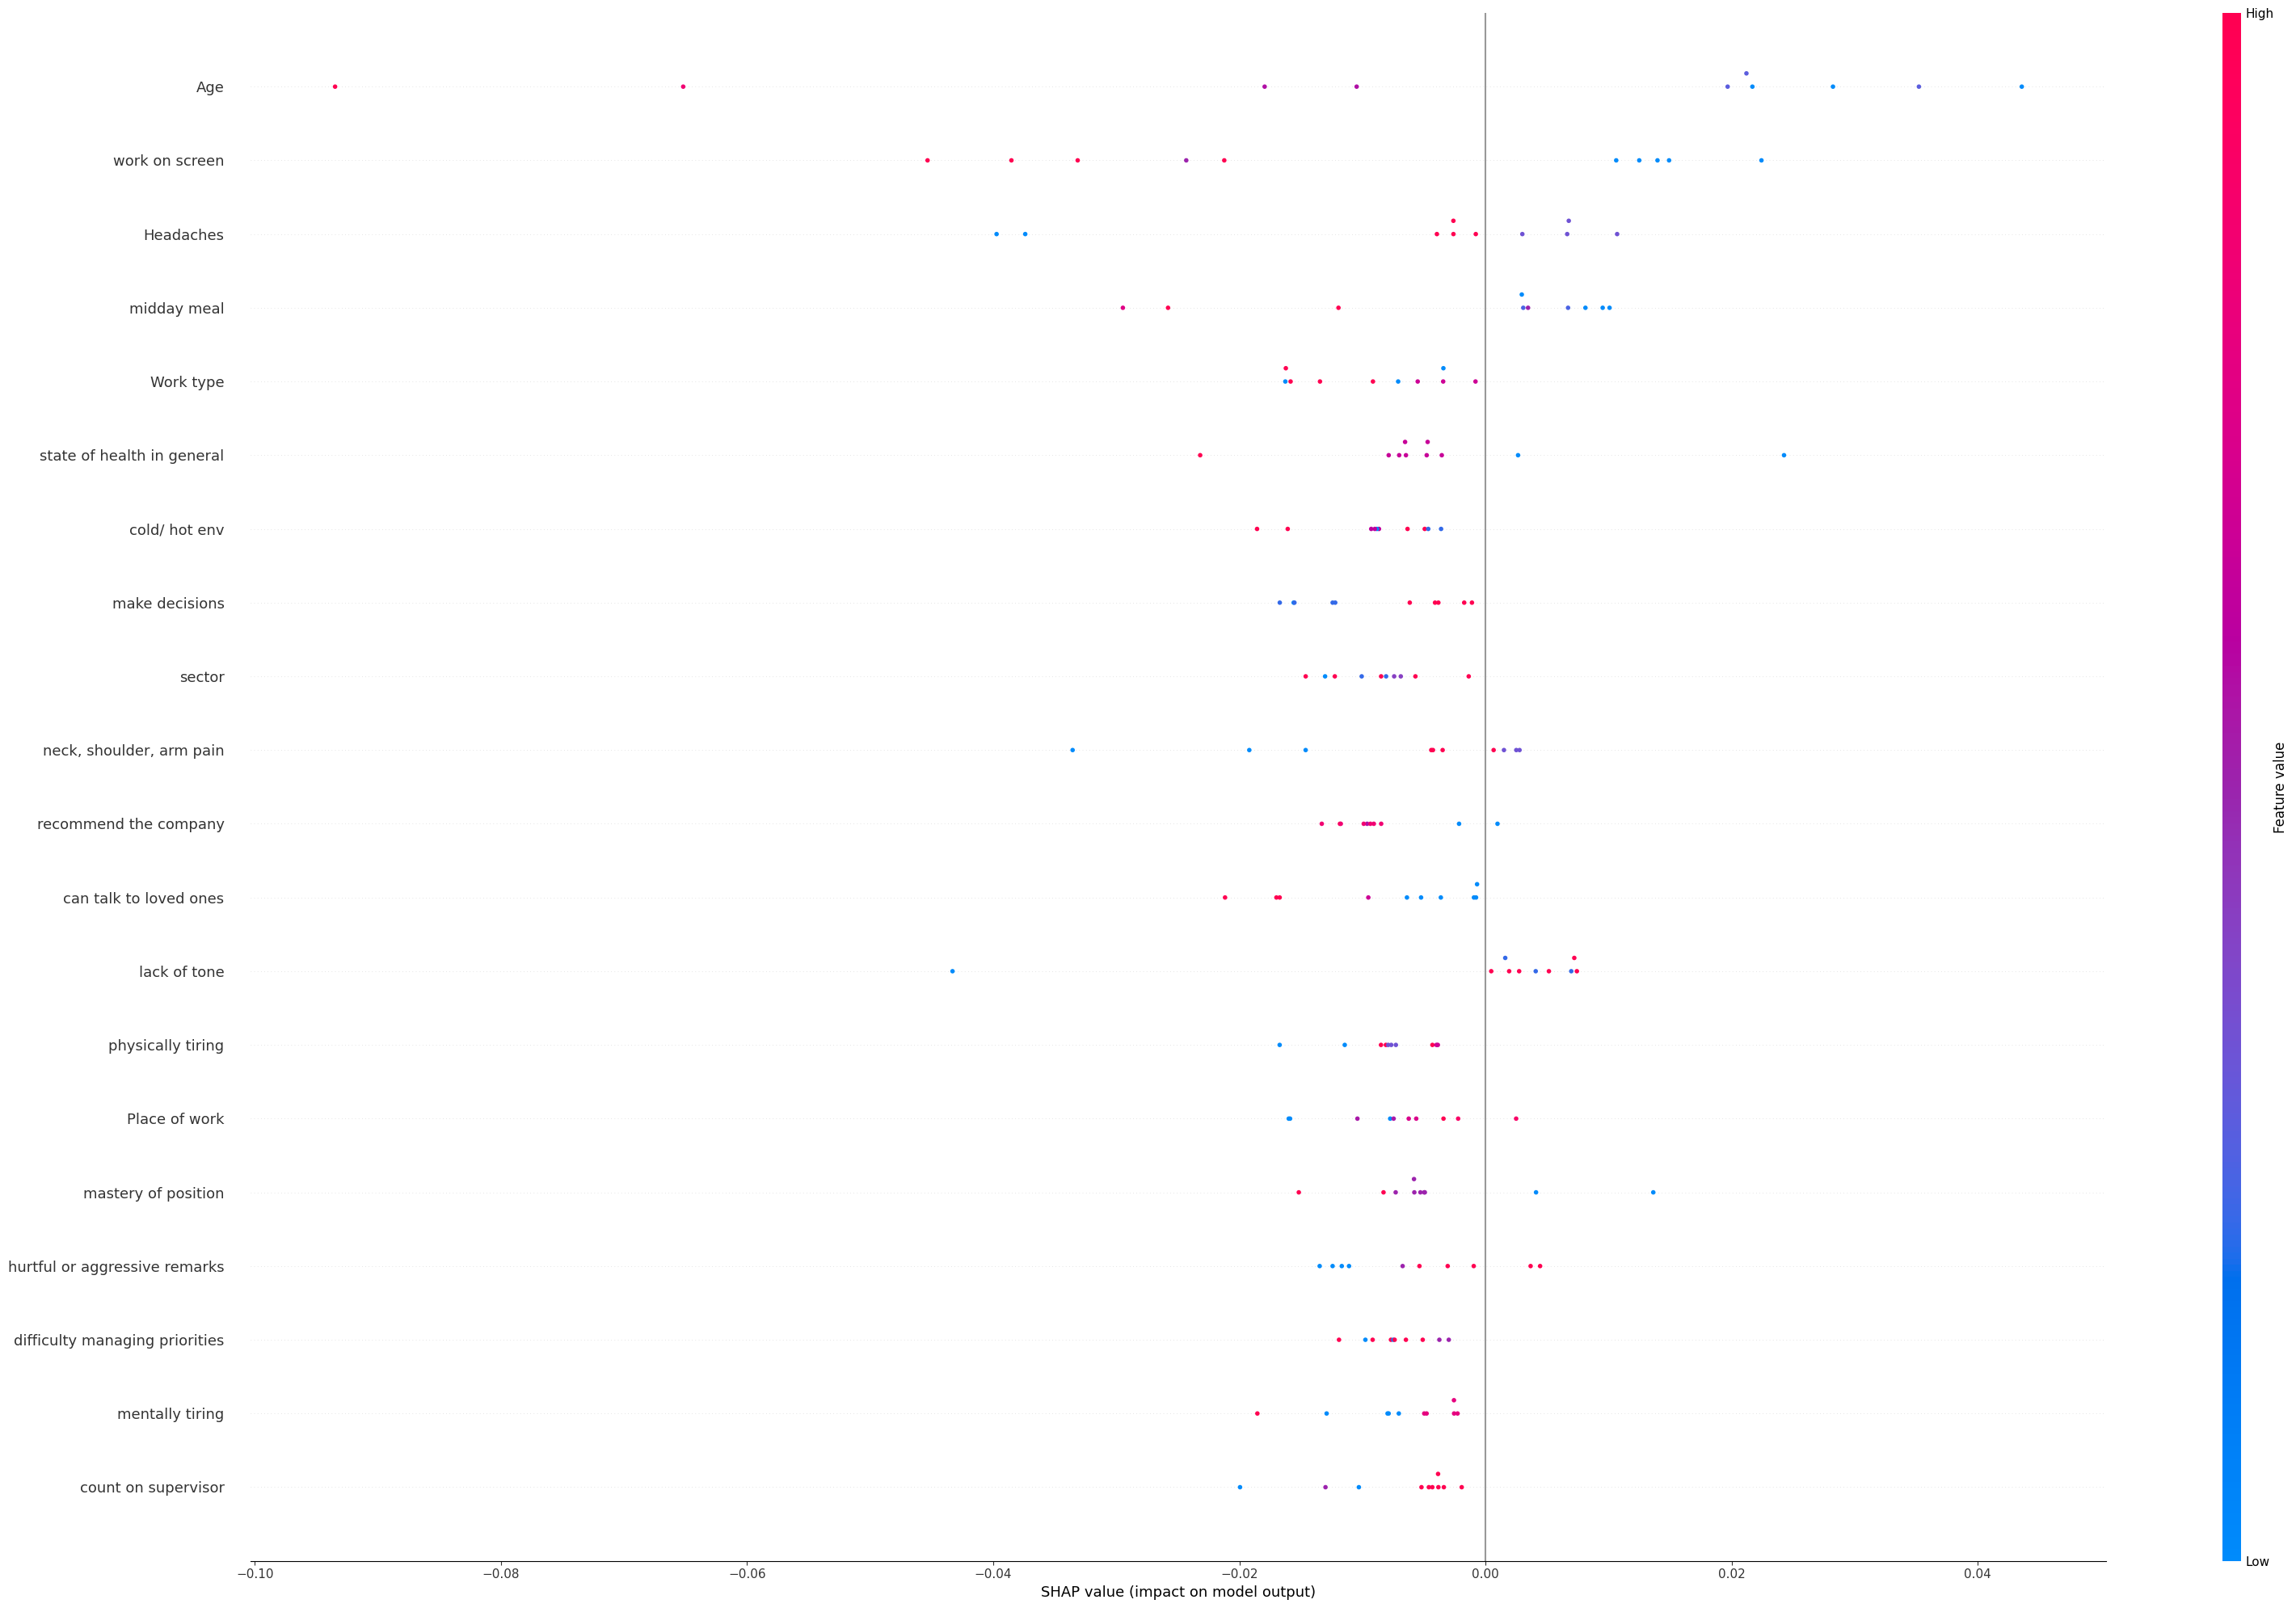

In [14]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/summary_plot_for_10_samples.png')
plt.show()

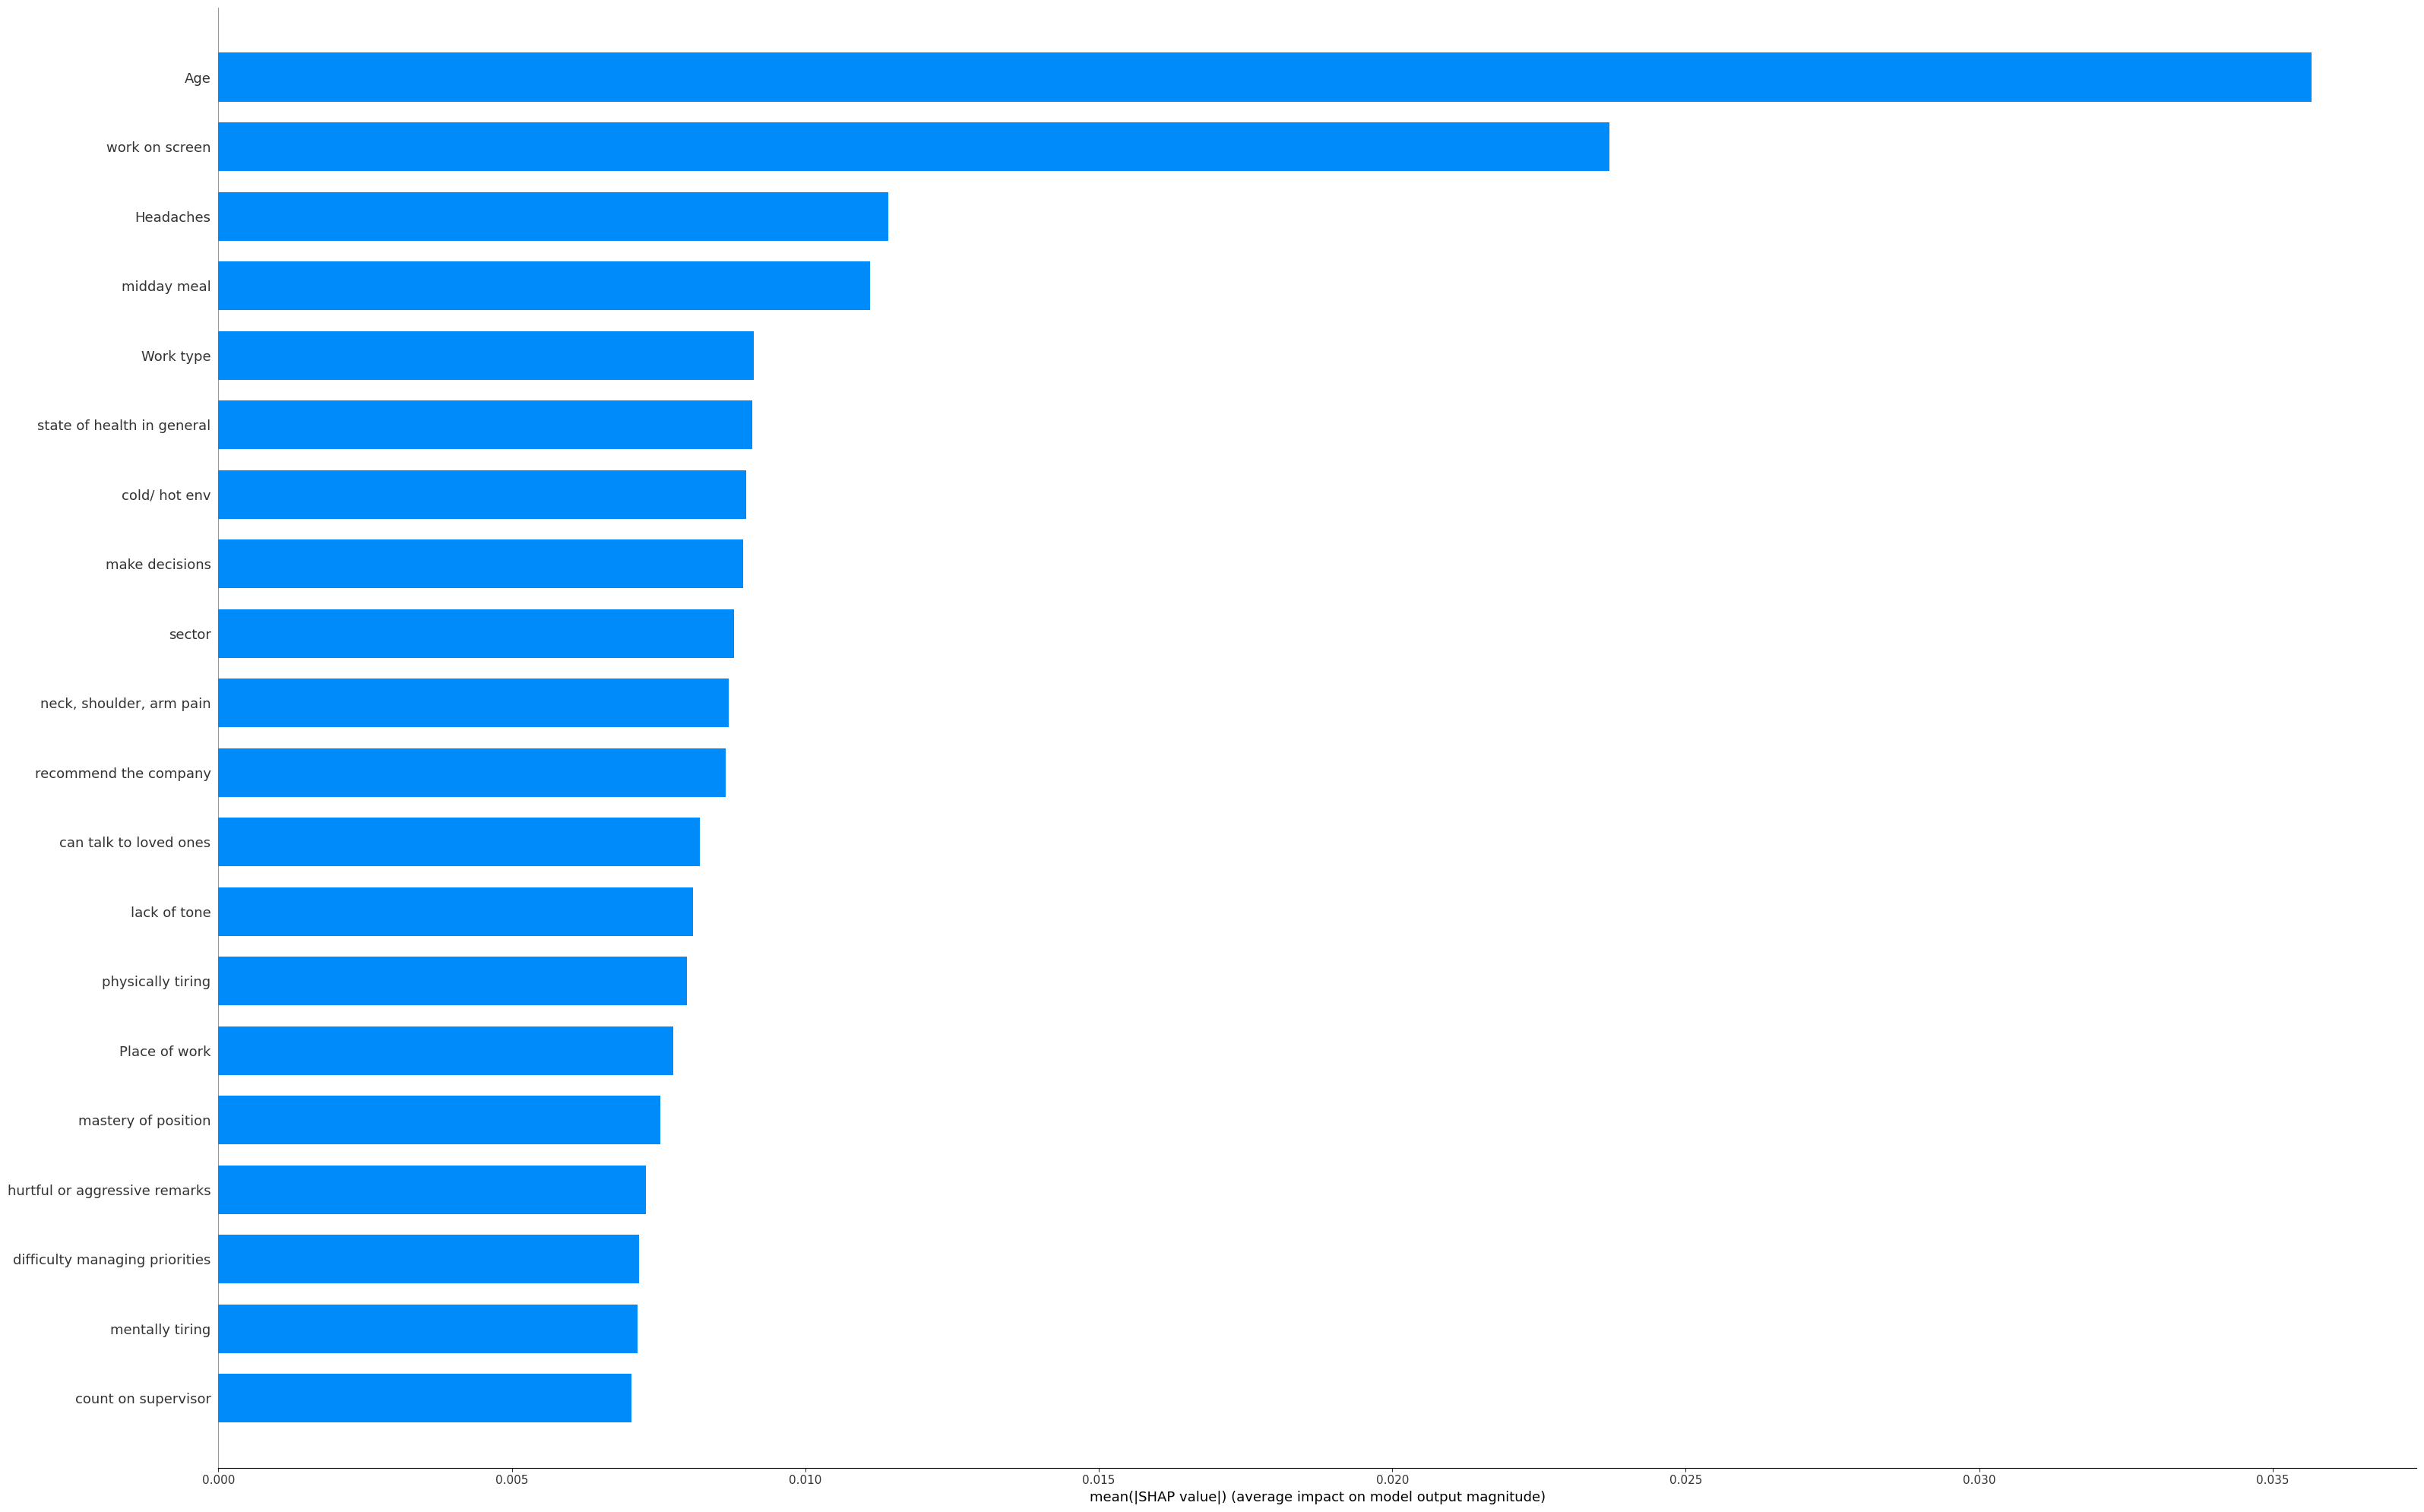

In [15]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/summary_plot_bar_for_10_samples.png')
plt.show()

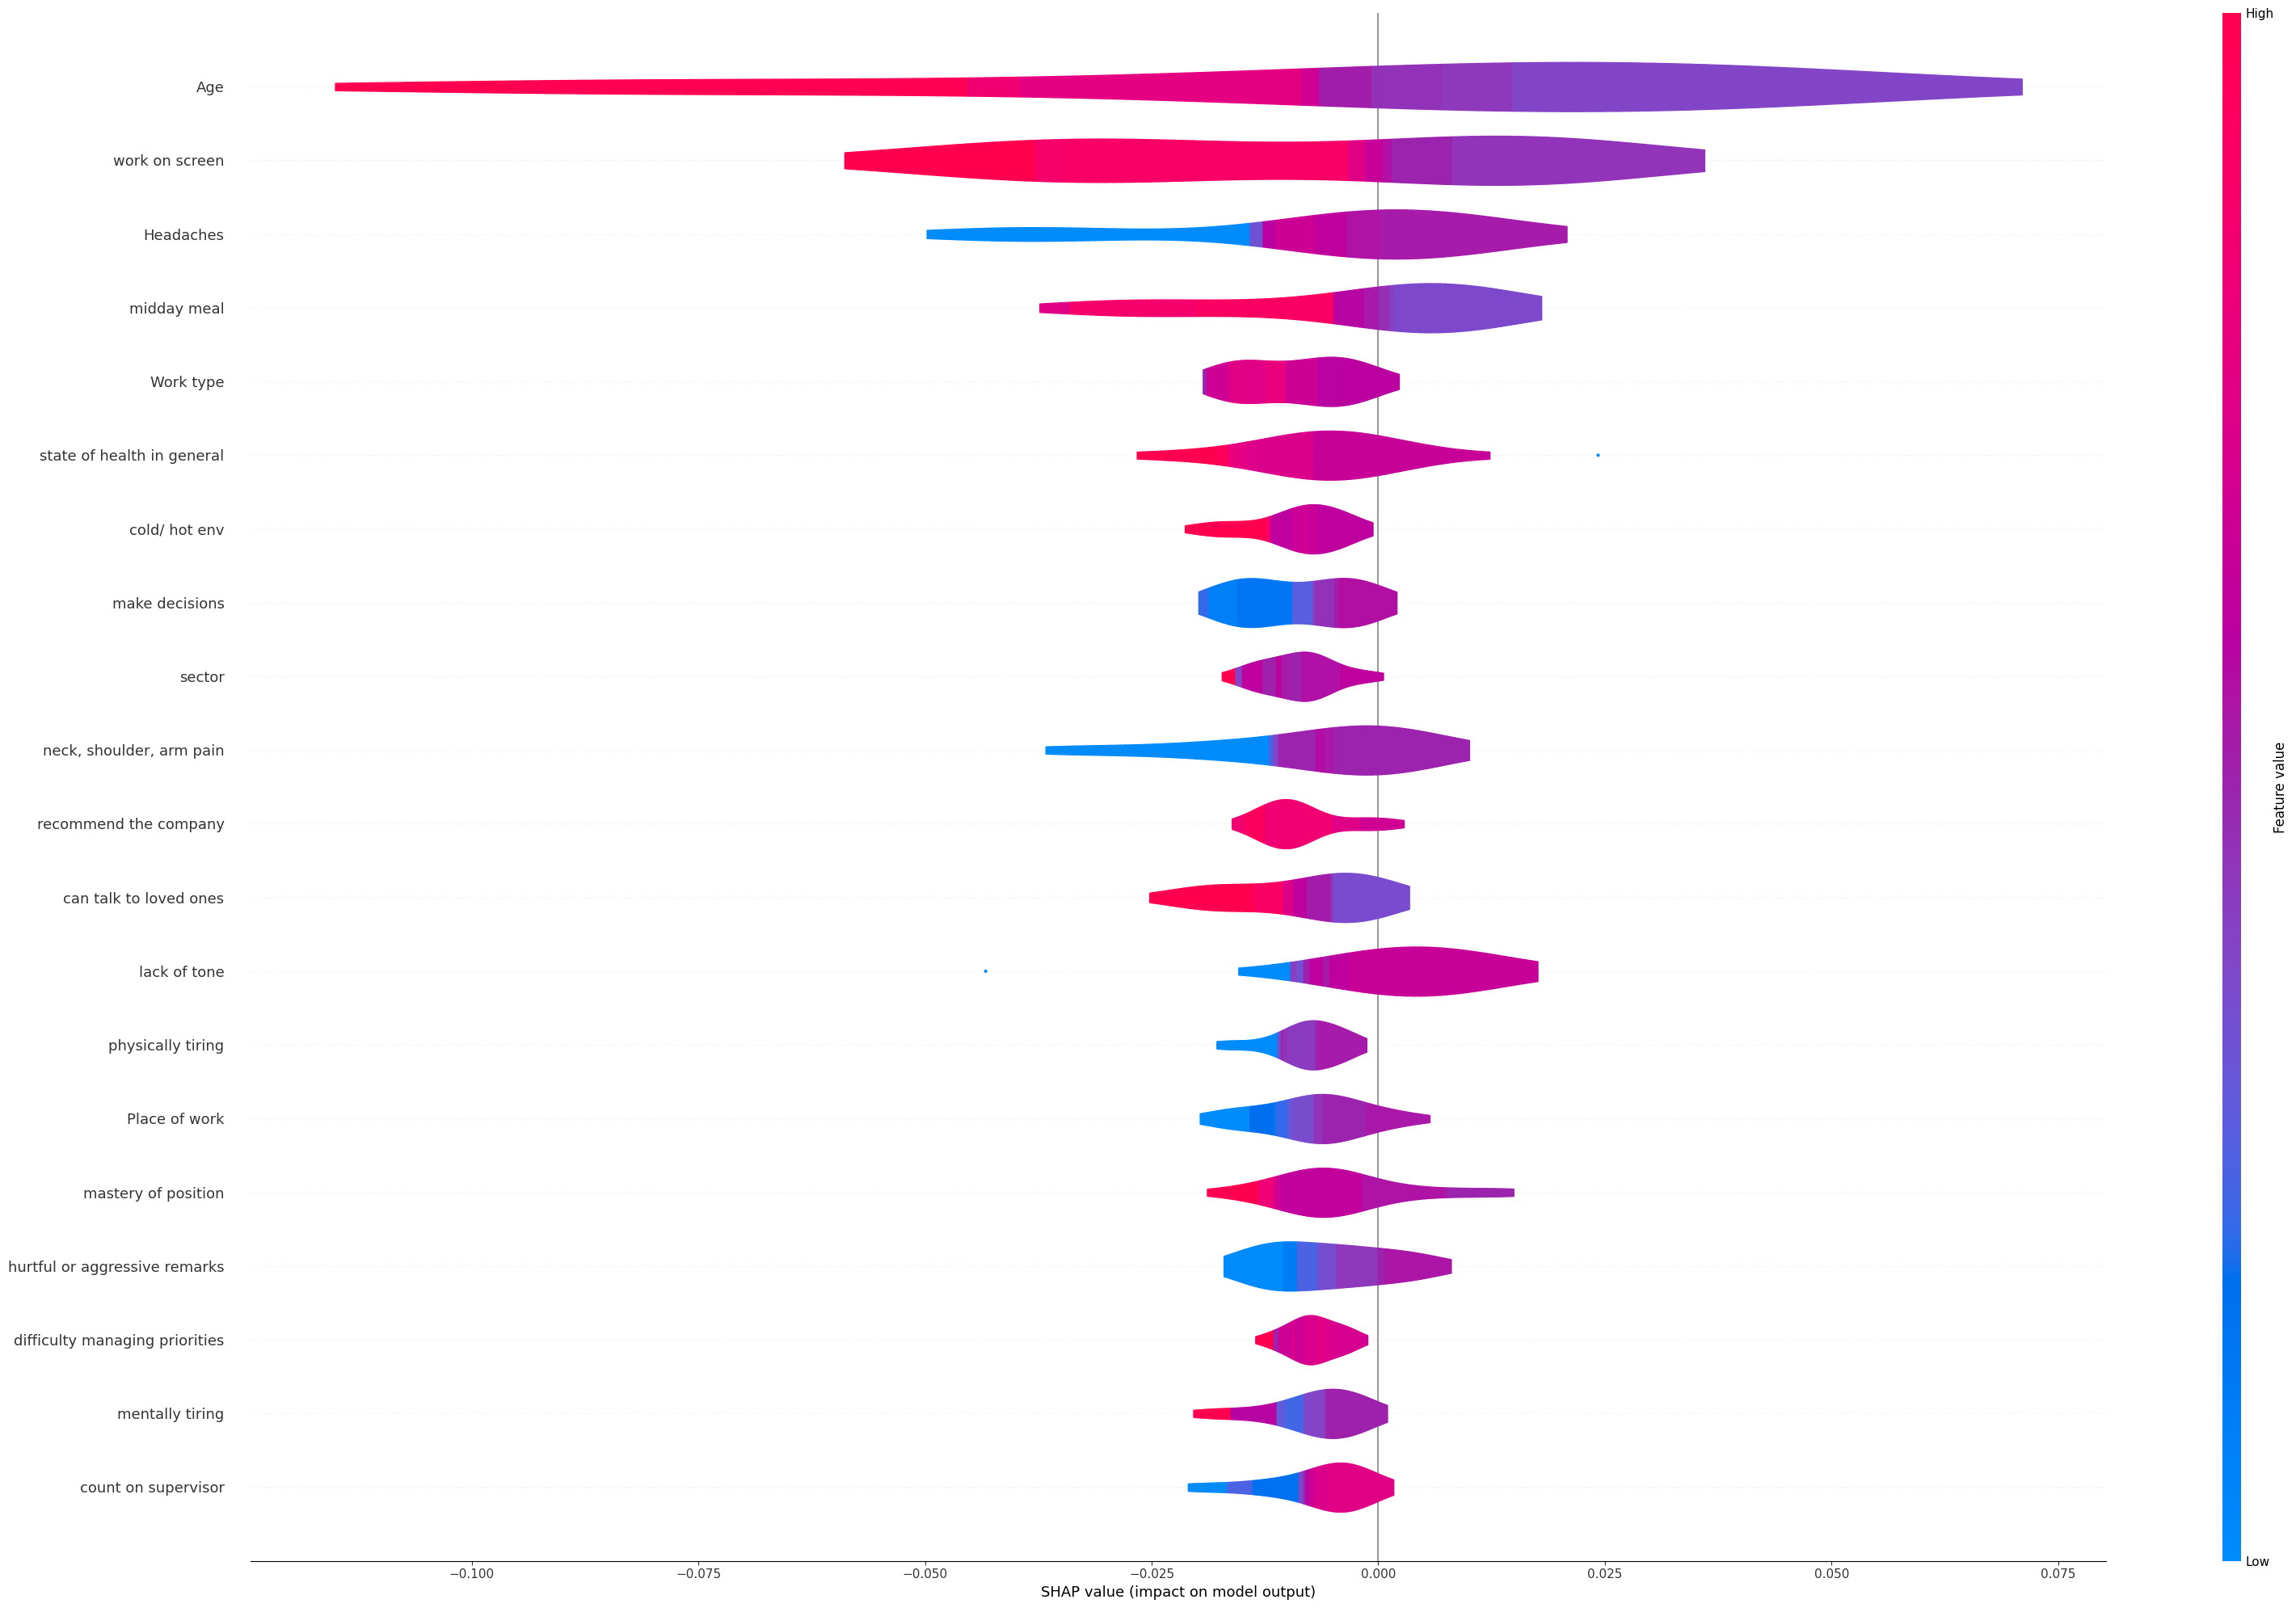

In [16]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_type="violin", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/summary_plot_violin_for_10_samples.png')
plt.show()

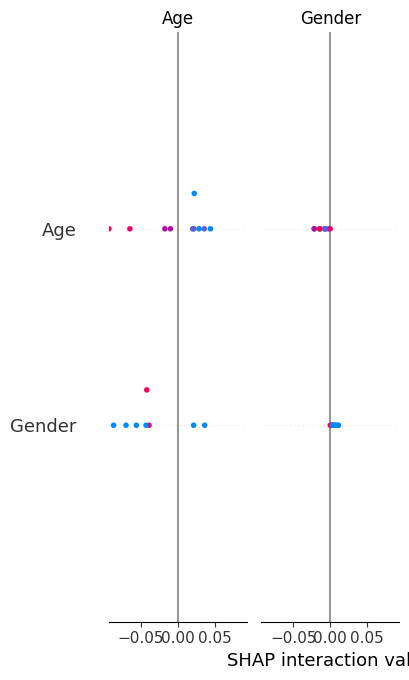

In [17]:
# Shap interaction values

shap.summary_plot(shap_values, X_test[start_index:end_index], plot_type="bar", plot_size=(18,12), show=False)
plt.savefig('outputs/02_01_shap/summary_plot_bar_interaction_for_10_samples.png')
plt.show()

In [18]:
# Calculate shapley values for all data
s_time = time.time()
shap_values_all = explainer.shap_values(X_test)
e_time = time.time()
print(time_e(s_time, e_time, "Shapley values for all data"))

Elapsed time to compute Shapley values for all data: 22 minutes and 37 seconds


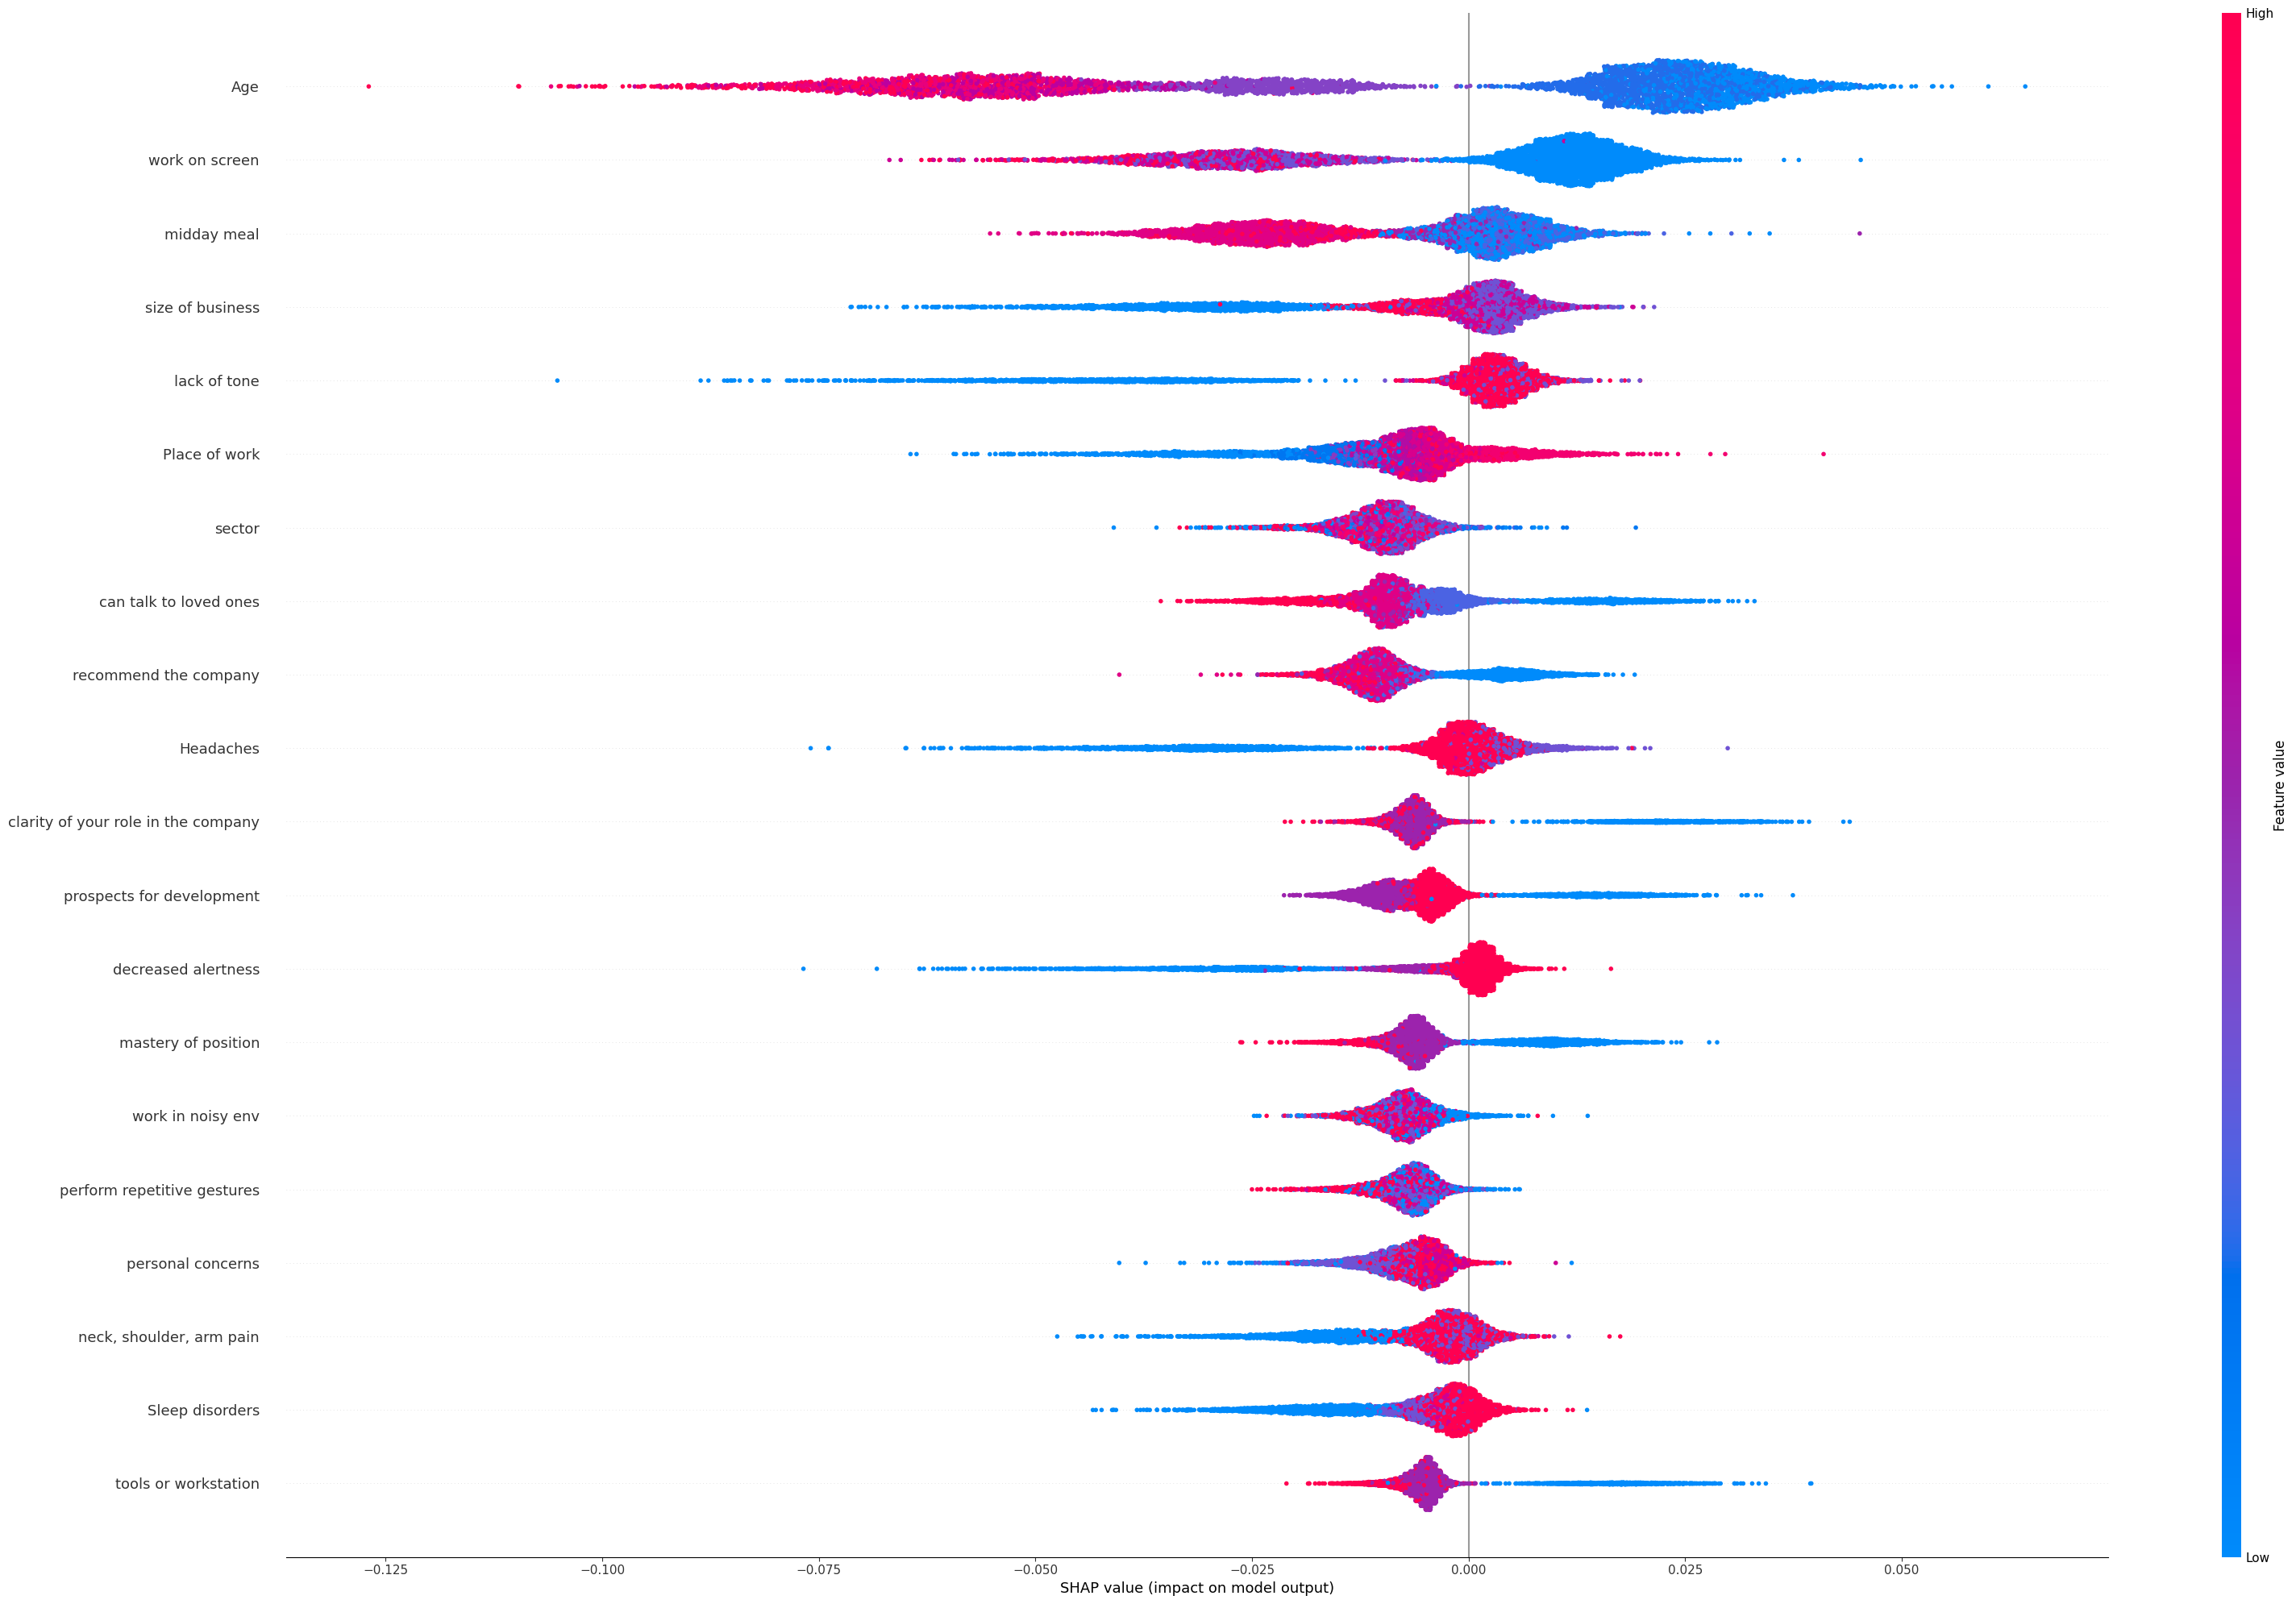

Elapsed time to compute Summary plot for all data: 0 minutes and 2 seconds


In [19]:
s_time = time.time()
shap.summary_plot(shap_values_all[...,1], X_test, plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/shap_summary_plot_all.png')
plt.show()
e_time = time.time()
print(time_e(s_time, e_time, "Summary plot for all data"))

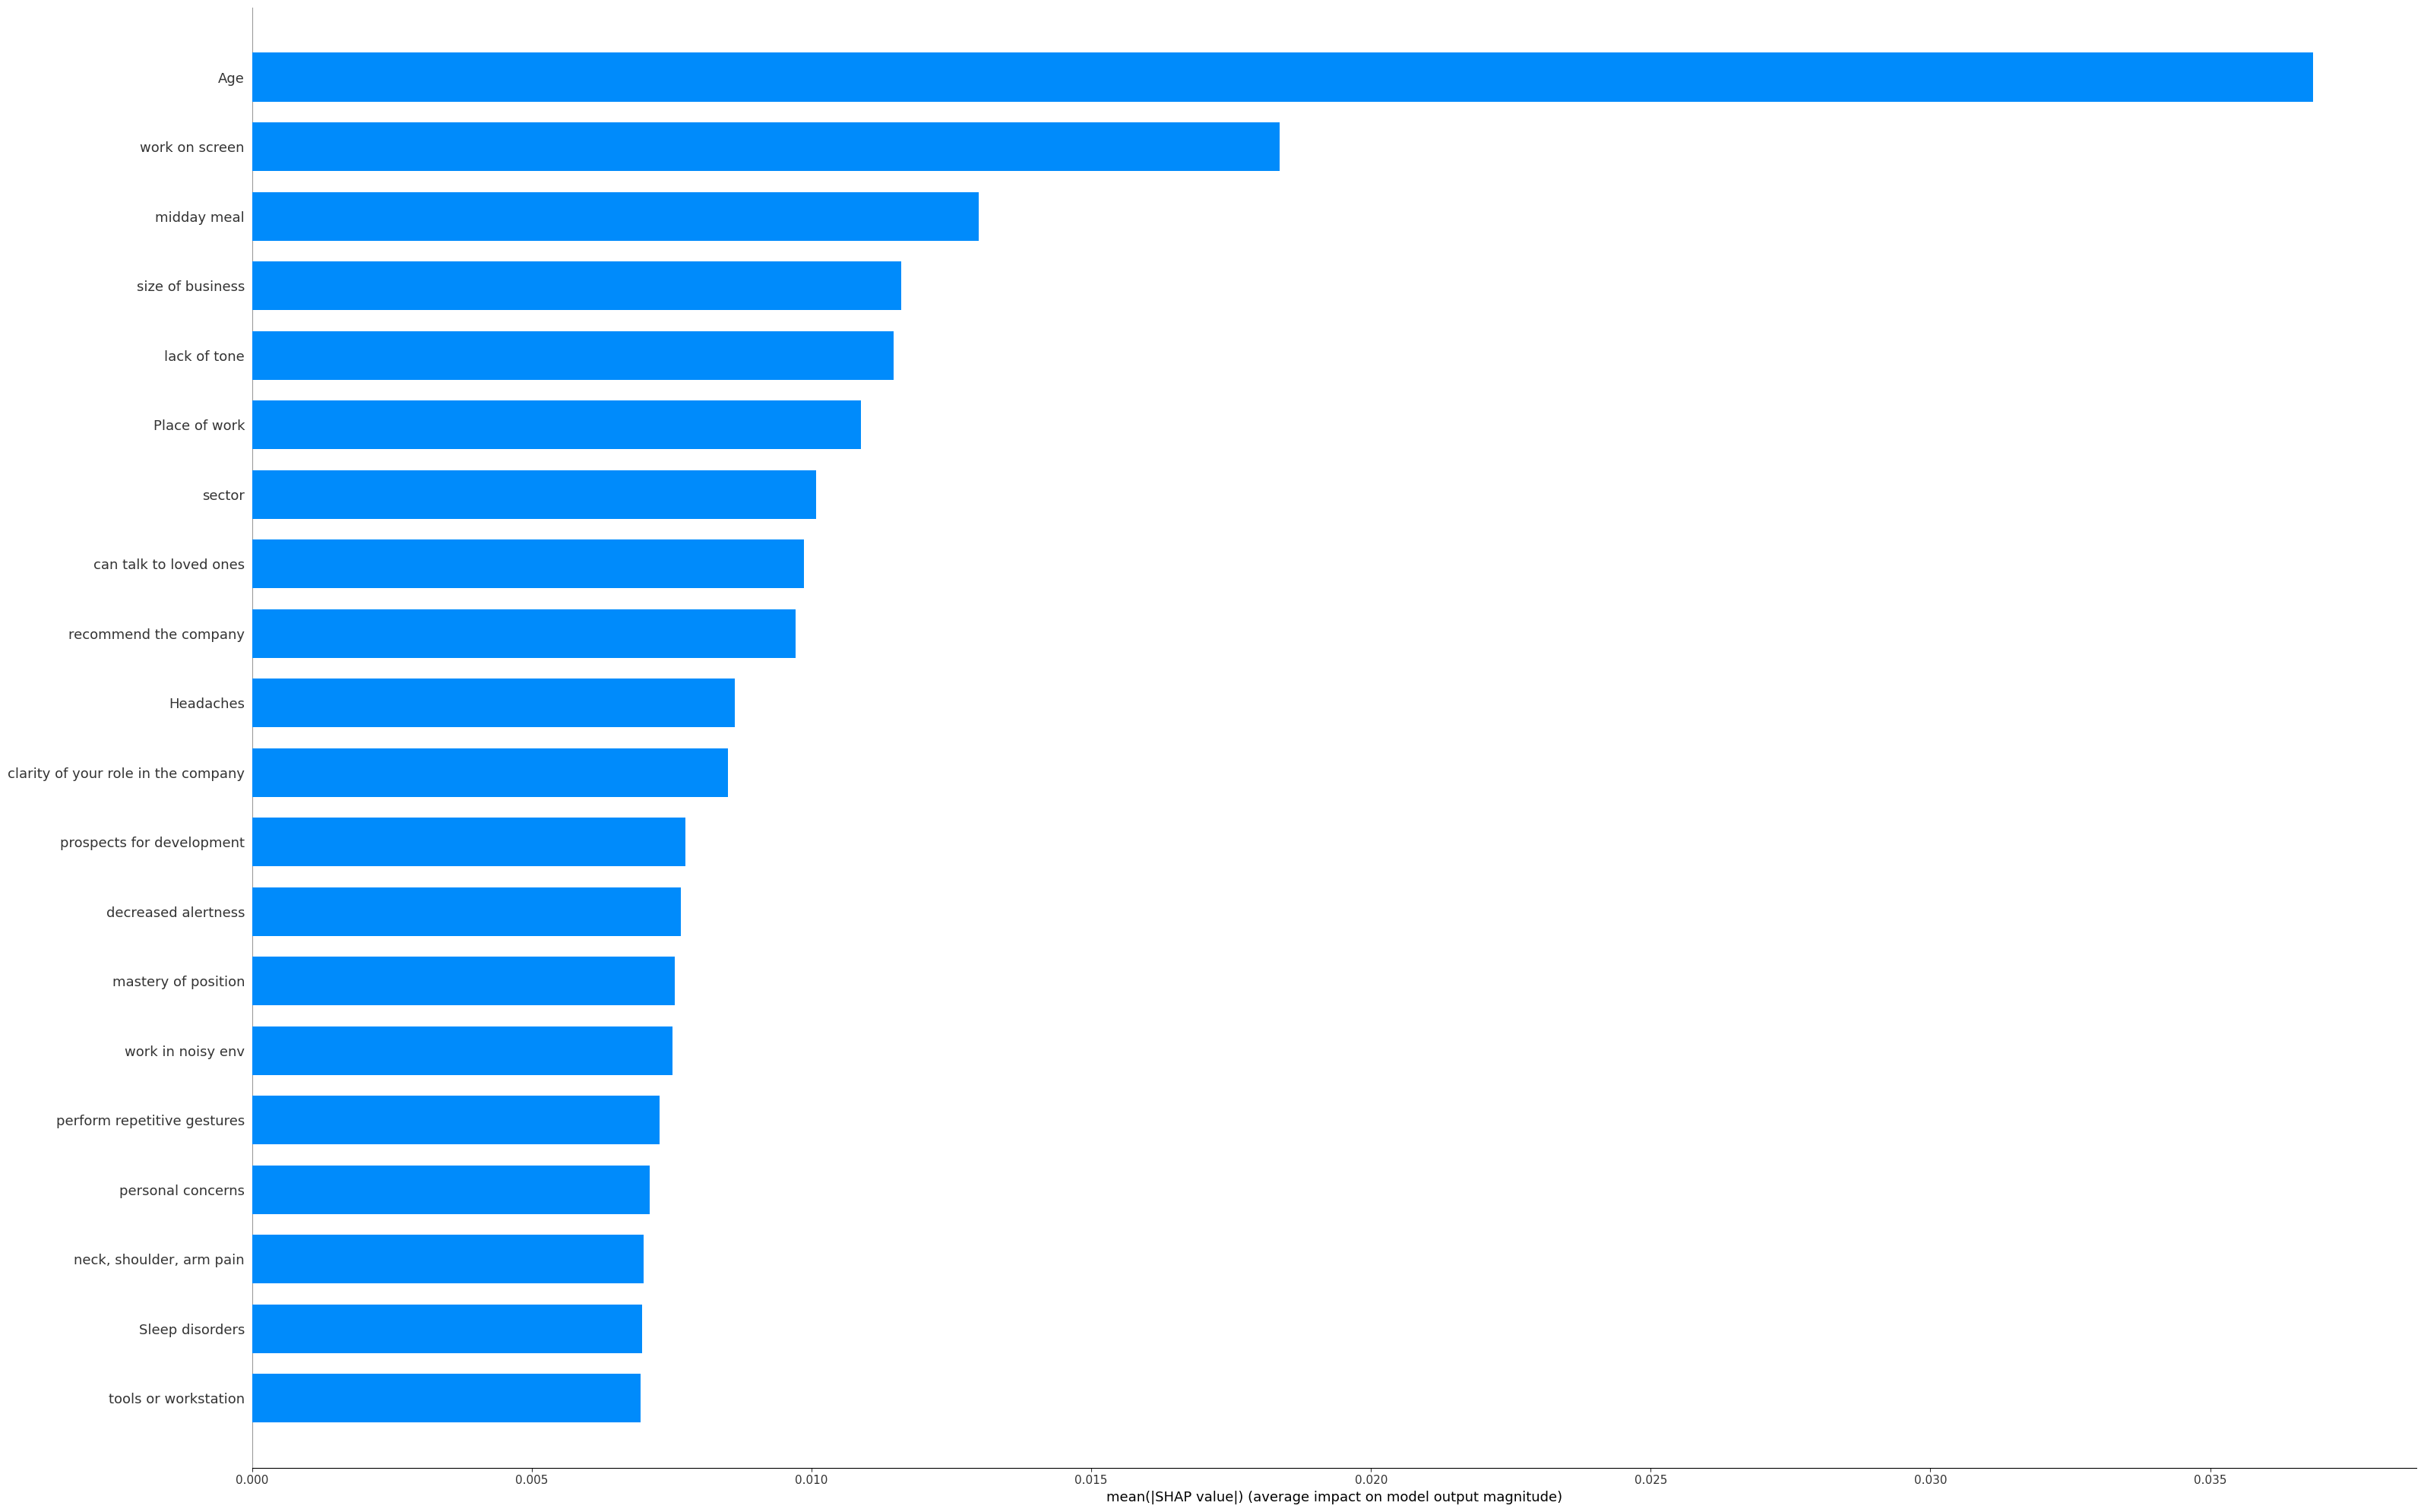

In [20]:
shap.summary_plot(shap_values_all[...,1], X_test, plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/shap_summary_plot_bar_all.png')
plt.show() 

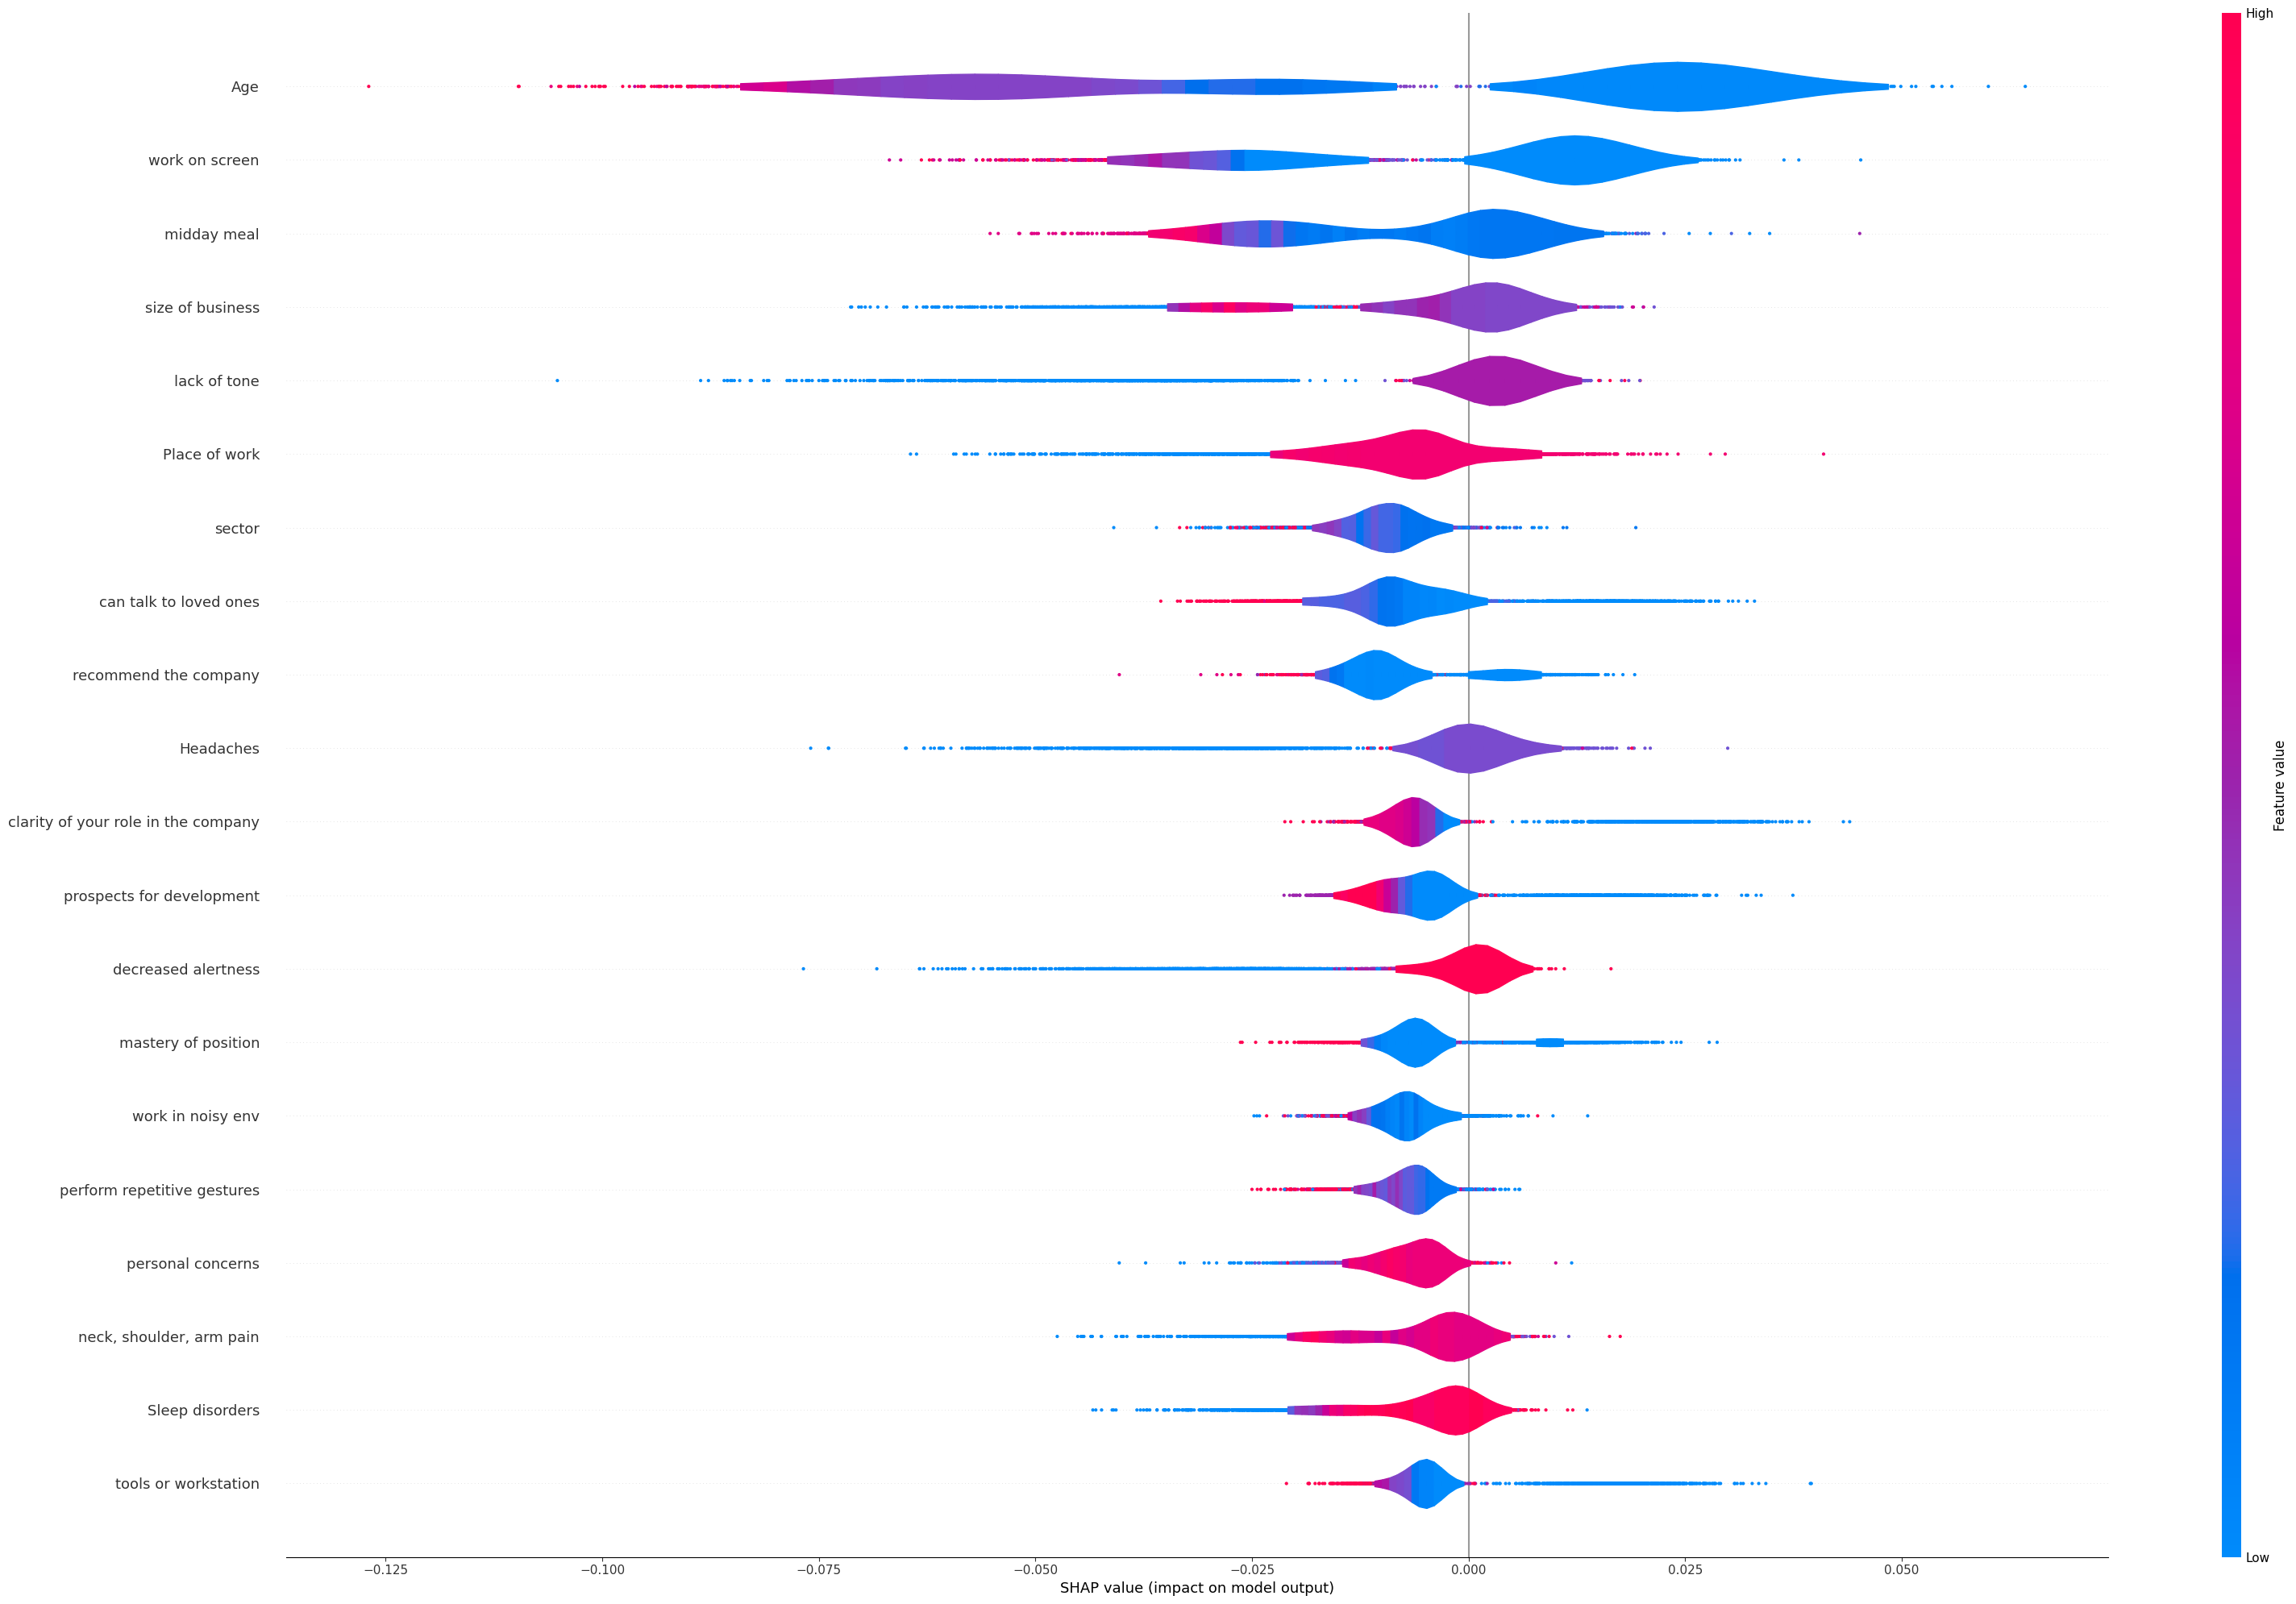

In [21]:
shap.summary_plot(shap_values_all[...,1], X_test, plot_type="violin", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/shap_summary_plot_violin_all.png')
plt.show()

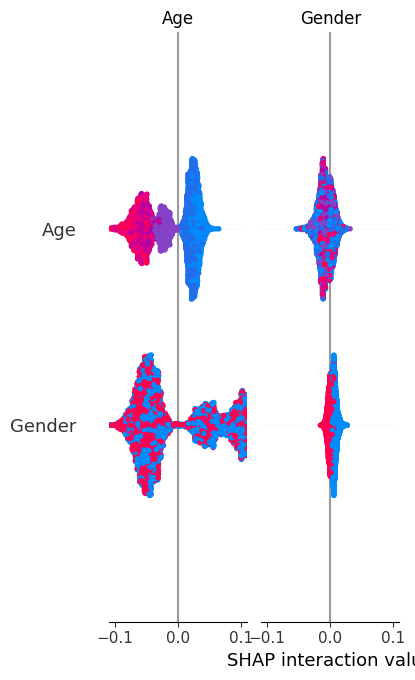

In [22]:
# get the most important feature

shap.summary_plot(shap_values_all, X_test, plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/shap_summary_plot_bar_interaction_all.png')
plt.show()

### XGBoost
max_depth = 3

In [23]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({"eta": 1, "max_depth": 3, "base_score": 0, "lambda": 0}, Xd, 1)

print("Model error =", np.linalg.norm(y - model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 61.696747
0:[Age<2] yes=1,no=2,missing=2,gain=56.1571045,cover=28758
	1:[prospects for development<0] yes=3,no=4,missing=4,gain=22.2964478,cover=14401
		3:[lack of tone<1] yes=7,no=8,missing=8,gain=5.56782532,cover=2085
			7:leaf=0.185840711,cover=339
			8:leaf=0.32588774,cover=1746
		4:[lack of tone<1] yes=9,no=10,missing=10,gain=15.6127014,cover=12316
			9:leaf=0.121079795,cover=2519
			10:leaf=0.209349796,cover=9797
	2:[clarity of your role in the company<0] yes=5,no=6,missing=6,gain=12.4761658,cover=14357
		5:[Gender<1] yes=11,no=12,missing=12,gain=2.64101028,cover=1348
			11:leaf=0.172680408,cover=776
			12:leaf=0.262237757,cover=572
		6:[work on screen<1] yes=13,no=14,missing=14,gain=9.30841064,cover=13009
			13:leaf=0.133025661,cover=7367
			14:leaf=0.0790499821,cover=5642



In [24]:
# Calculate model accuracy and F1 score

y_pred = model.predict(Xd) > 0.5
print(f"F1 Score {f1_score(y, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y, y_pred)}")

F1 Score 0.455526525048279
Accuracy 0.8366367619445024


In [25]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)
shap_values = explanation.values

# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

2.9802322e-08

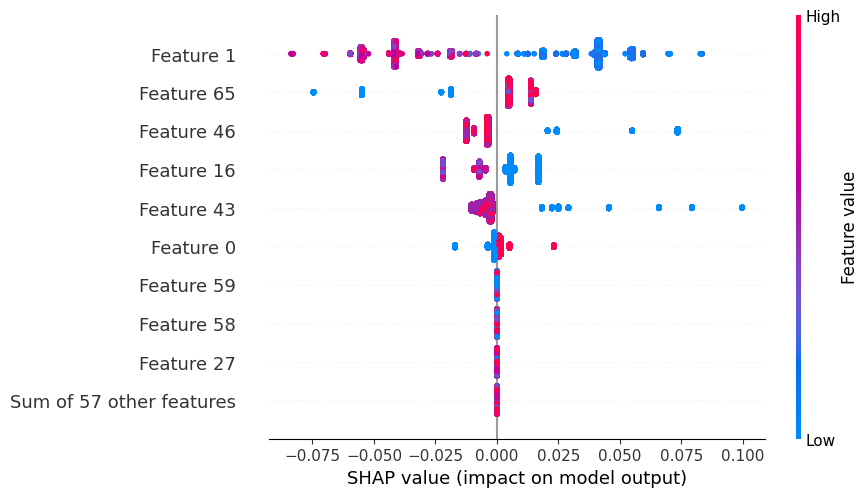

In [26]:
"""
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.
The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution
of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).
"""
shap.plots.beeswarm(explanation, show=False)
plt.savefig('outputs/02_01_shap/shap_beeswarm_plot_xg_4.png')
plt.show()

In [27]:
st = time.time()
clustering = shap.utils.hclust(X, y)
et = time.time()
print(time_e(st, et, "Clustering"))

67it [00:53,  1.02s/it]                        

Elapsed time to compute Clustering: 0 minutes and 54 seconds


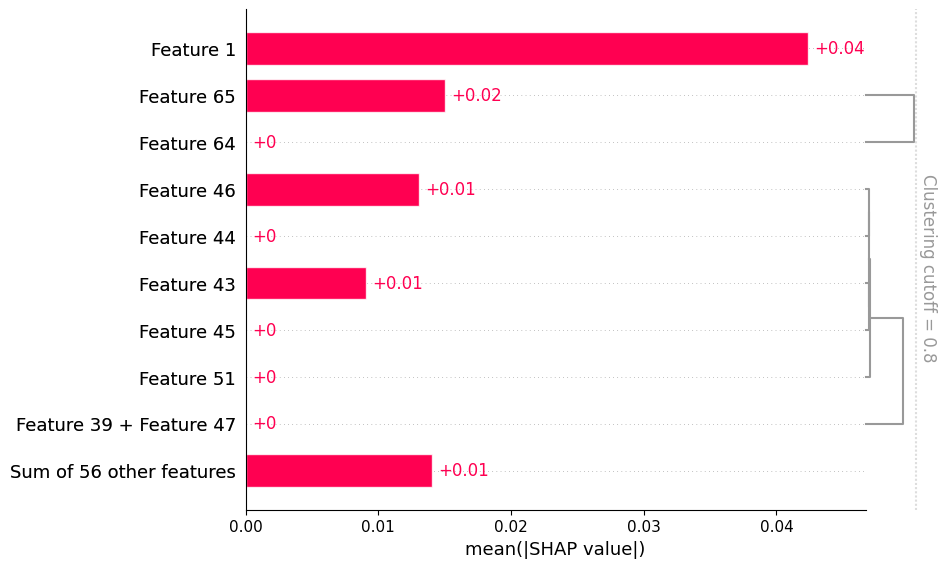

In [28]:
shap.plots.bar(explanation, clustering=clustering, clustering_cutoff=0.8, show=False)
plt.savefig('outputs/02_01_shap/shap_cluster_md_3.png')
plt.show()

### XGBoost

max_depth = 4

In [29]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y) 
model = xgboost.train({"eta": 1, "max_depth": 4, "base_score": 0, "lambda": 0}, Xd, 1)
baseline_error = np.linalg.norm(y - model.predict(Xd))
print("Baseline Model error =", baseline_error)
print(model.get_dump(with_stats=True)[0])

Baseline Model error = 61.457138
0:[Age<2] yes=1,no=2,missing=2,gain=56.1571045,cover=28758
	1:[prospects for development<0] yes=3,no=4,missing=4,gain=22.2964478,cover=14401
		3:[lack of tone<1] yes=7,no=8,missing=8,gain=5.56782532,cover=2085
			7:[other parts of the body pain<0] yes=15,no=16,missing=16,gain=1.61082745,cover=339
				15:leaf=-0,cover=41
				16:leaf=0.21140939,cover=298
			8:[Security is a priority<3] yes=17,no=18,missing=18,gain=2.48753357,cover=1746
				17:leaf=0.305411428,cover=1349
				18:leaf=0.395466,cover=397
		4:[lack of tone<1] yes=9,no=10,missing=10,gain=15.6127014,cover=12316
			9:[long-term illness<1] yes=19,no=20,missing=20,gain=2.91556549,cover=2519
				19:leaf=0.112101912,cover=2355
				20:leaf=0.25,cover=164
			10:[size of business<1] yes=21,no=22,missing=22,gain=9.77127075,cover=9797
				21:leaf=0.158148155,cover=2700
				22:leaf=0.228829086,cover=7097
	2:[clarity of your role in the company<0] yes=5,no=6,missing=6,gain=12.4761658,cover=14357
		5:[Gender

In [30]:
# Calculate model accuracy and F1 score

y_pred = model.predict(Xd)
y_pred = [1 if i > 0.5 else 0 for i in y_pred] # convert to binary
print(f"F1 Score {f1_score(y, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y, y_pred)}")

F1 Score 0.455526525048279
Accuracy 0.8366367619445024


In [31]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

5.9604645e-08

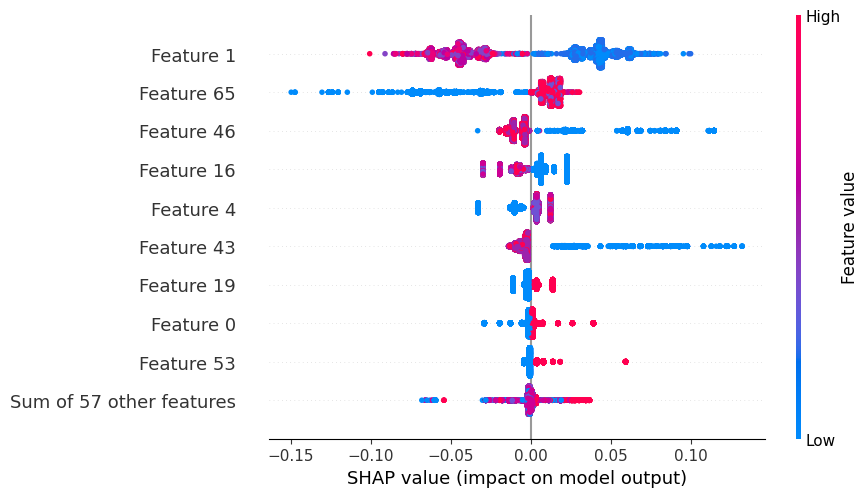

In [32]:
shap.plots.beeswarm(explanation, show=False) # plot the SHAP values
plt.figsize=(32,12)
plt.savefig('outputs/02_01_shap/shap_beeswarm_plot_xg_4.png')
plt.show()

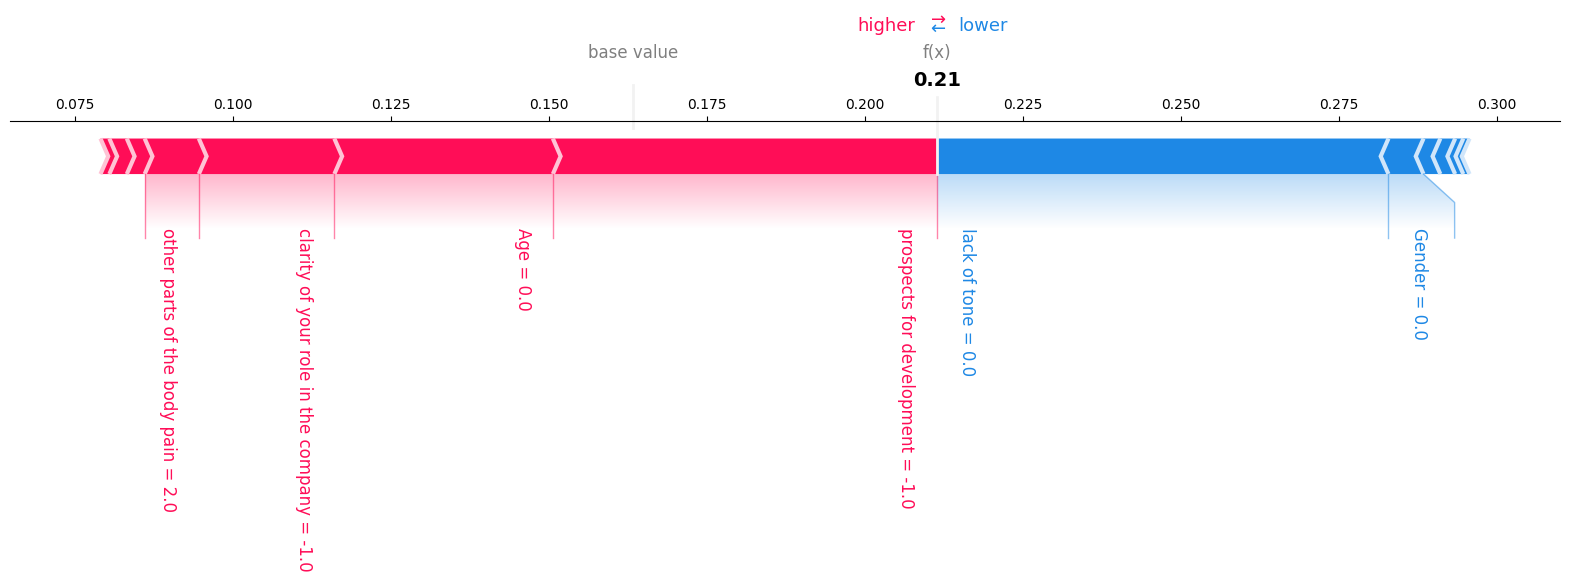

In [33]:
shap.plots.force(explanation.base_values[0], shap_values[0,:], X.iloc[0,:], text_rotation=270, matplotlib=True, show= False) # shows the shap values for the second prediction
plt.savefig('outputs/02_01_shap/shap_force_plot_xg_4.png')
plt.show()

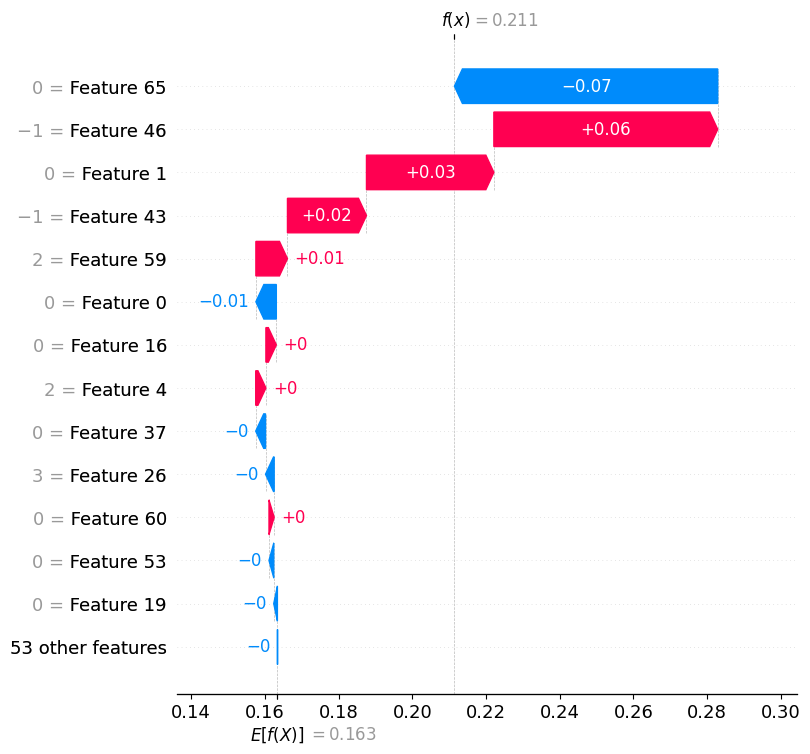

In [34]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(explanation[0,:], max_display=14, show=False)
plt.figsize=(32,18)
plt.savefig('outputs/02_01_shap/shap_waterfall_plot_xg_4.png')
plt.show()

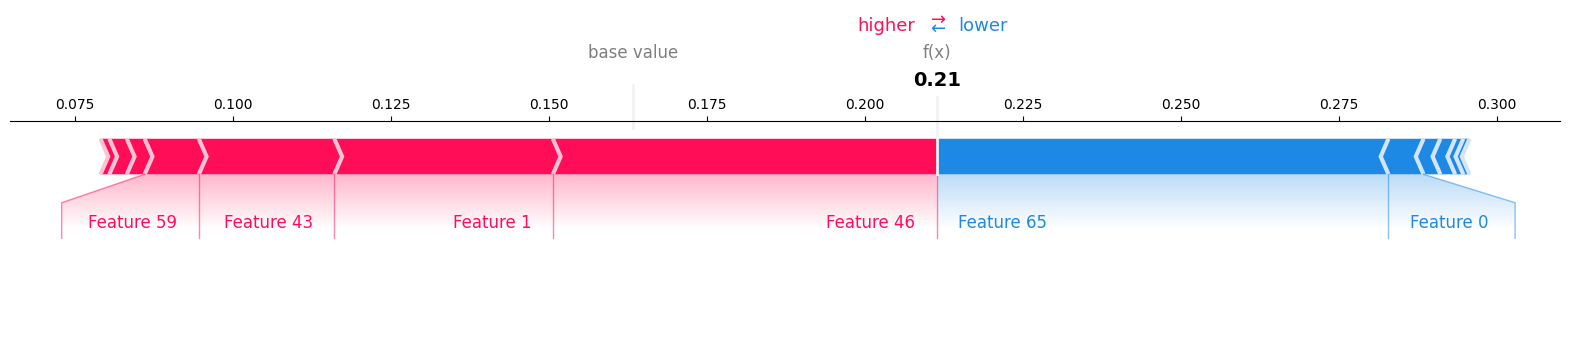

In [35]:
shap.plots.force(explainer.expected_value, shap_values[0, ...], show= False, matplotlib=True) # shap_values[0, ...] is the SHAP values for the first instance in the dataset ... is a numpy slice that means "all of the other axes"
plt.savefig('outputs/02_01_shap/shap_force_plot_xg_4_2.png')
plt.show()

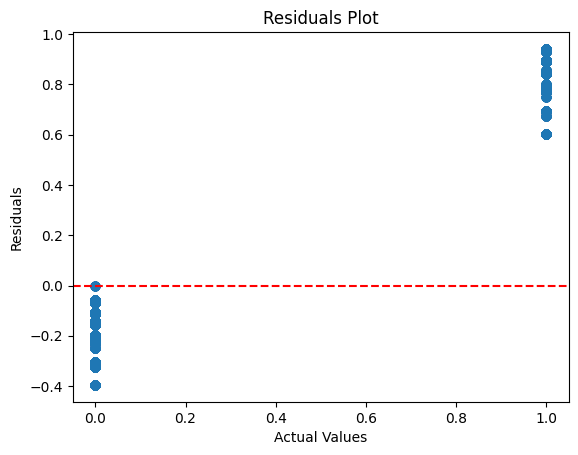

In [36]:
residuals = y - model.predict(Xd)
plt.scatter(y, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# save the plot
plt.savefig('outputs/02_01_shap/residuals_plot.png')
plt.show()

In [37]:
st = time.time()
clustering = shap.utils.hclust(X, y)
et = time.time()
print(time_e(st, et, "Clustering"))

67it [00:52,  1.02s/it]                        

Elapsed time to compute Clustering: 0 minutes and 54 seconds


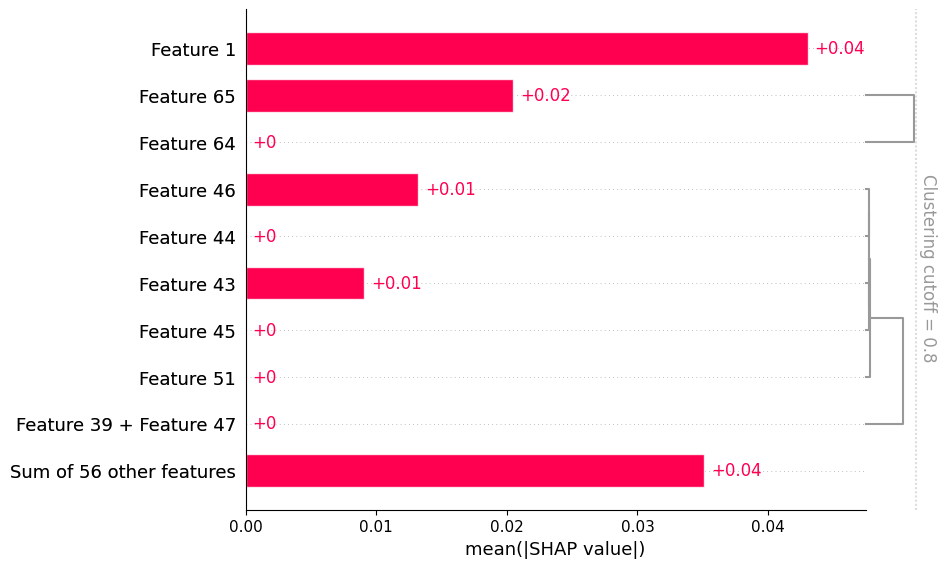

In [38]:
shap.plots.bar(explanation, clustering=clustering, clustering_cutoff=0.8, show=False)
plt.savefig('outputs/02_01_shap/shap_cluster_md_3.png')
plt.show()

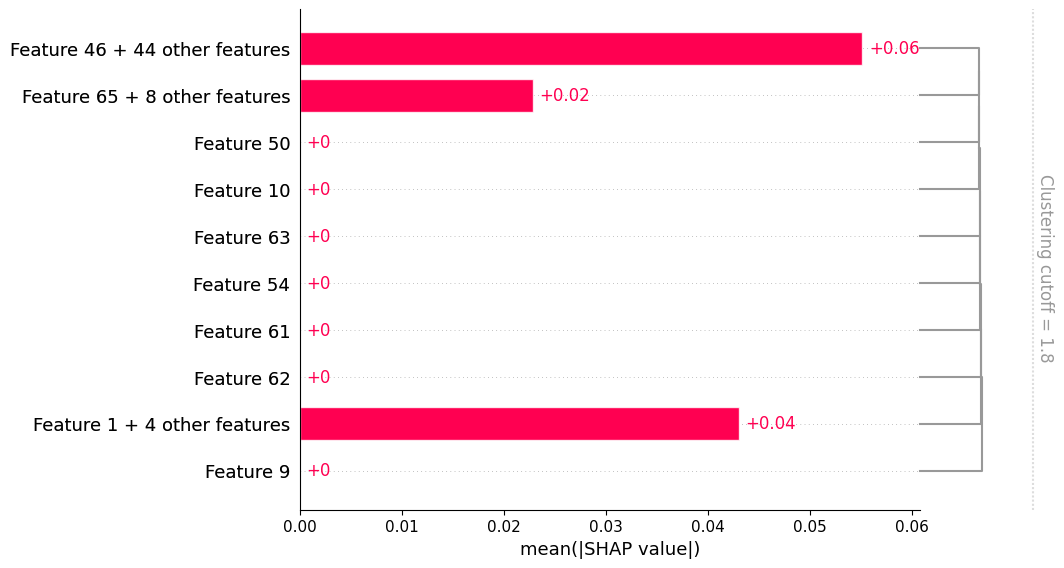

In [39]:
shap.plots.bar(explanation, clustering=clustering, clustering_cutoff=1.8, show=False)
plt.savefig('outputs/02_01_shap/shap_cluster_md_3_1_8.png')
plt.show()